In [19]:
import pandas as pd
import numpy as np
import dtale
import plotly.express as px
import Orange
from Orange.data import Table,Domain, DiscreteVariable, ContinuousVariable
from orangecontrib.associate.fpgrowth import *

In [3]:
data_list = []
data = pd.DataFrame()
f = open("grocery_data.csv", "r")
for x in f:
    row = x.replace("\n","").split(",")
    data_list.append(row)
f.close()
for row in range(len(data_list)):
    for col in data_list[row]:
        data.loc[row,col]=1
data.fillna(0,inplace=True)


In [4]:
print("Shape of Data: ",data.shape)
print('Number of Transactions: ',data.shape[0])
print('Number of Items: ',data.shape[1])


Shape of Data:  (9835, 169)
Number of Transactions:  9835
Number of Items:  169


In [6]:
def get_item_perc(input_df):
    temp_df=input_df.copy()
    df_item_count = pd.DataFrame()
    count_list = []
    df_item_count['item_name'] = temp_df.columns
    for row in df_item_count['item_name']:
        count_list.append(temp_df[row].sum())
    df_item_count['item_count'] = count_list
    df_item_count['item_perc'] = df_item_count['item_count']/df_item_count['item_count'].sum()
    df_item_count.sort_values(by=['item_count'],ascending=False,inplace=True)
    df_item_count.reset_index(drop=True,inplace=True)
#     print(df_item_count.columns)
#     print(df_item_count.index)
    for perc in df_item_count.index:
        if perc==0:
            df_item_count['total_sales_perc'] = df_item_count['item_perc']
        else:
            df_item_count['total_sales_perc'][perc] = df_item_count['item_perc'][perc]+df_item_count['total_sales_perc'][perc-1]
    return df_item_count

In [7]:
item_perc_data= get_item_perc(data)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [8]:
top20 = item_perc_data[:20]
top20
top5 = top20.head()

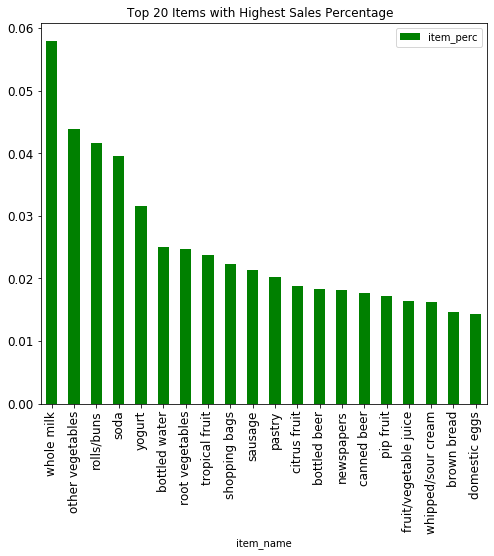

In [11]:
top20.plot.bar(x='item_name',
               y='item_perc',
               color='green',
               figsize=(8, 7),
               legend=True,
               fontsize=12,
               title="Top 20 Items with Highest Sales Percentage  ")

In [87]:
top20.to_csv('top20_grocery.csv',index=False)

In [14]:
def prune_dataset(input_df, length_trans,total_sales_perc):
    temp_df = input_df.copy()
    local_sales = get_item_perc(temp_df)
    essential_item = local_sales[local_sales['total_sales_perc'] <=total_sales_perc]
    essential_item = list(essential_item['item_name'].values)
    temp_df = temp_df[essential_item]
    temp_df = temp_df[temp_df.sum(axis=1) >= length_trans]
    temp_df.reset_index(drop=True,inplace=True)
    temp_df = temp_df.astype(int)
    return temp_df

In [15]:
pruned_data = prune_dataset(input_df=data, length_trans=2,total_sales_perc=0.4)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
print("Shape: ",pruned_data.shape)
print("Selected items: ", list(pruned_data.columns))

Shape:  (4585, 13)
Selected items:  ['whole milk', 'other vegetables', 'rolls/buns', 'soda', 'yogurt', 'bottled water', 'root vegetables', 'tropical fruit', 'shopping bags', 'sausage', 'pastry', 'citrus fruit', 'bottled beer']


In [17]:
pruned_data.to_csv('mba_pruned_data.csv',index=False)

In [25]:
fig = px.funnel(top5, x='item_perc', y='item_name')
fig.show()

In [86]:
fig1 = px.bar(top20, x='item_name', y='item_perc',color='item_perc',text='item_perc',title="Top 20 Items with Highest Sales Percentage  ")
fig1.update_traces( texttemplate='%{text:.2%}',textposition='outside')
fig1.update_layout(uniformtext_minsize=10)
fig1.show()

In [92]:
#plotly chart studio
import chart_studio
username = '##########'
api_key = '##########'
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [93]:
import chart_studio.plotly as py
py.plot(fig1, filename = 'top20_items_barchart', auto_open=False)

'https://plotly.com/~kunal_gupta26/8/'

In [94]:
import chart_studio.tools as tls
tls.get_embed('https://plot.ly/~kunal_gupta26/8/') #change to your url

'<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plot.ly/~kunal_gupta26/8.embed" height="525" width="100%"></iframe>'

In [21]:
input_assoc_rules = pruned_data 
domain_grocery = Domain([DiscreteVariable.make(name=item,values=['0', '1']) for item in input_assoc_rules.columns])
data_gro_1 = Orange.data.Table.from_numpy(domain=domain_grocery,  X=input_assoc_rules.as_matrix(),Y= None)
data_gro_1_en, mapping = OneHot.encode(data_gro_1, include_class=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [39]:
in_support=0.01
num_trans = input_assoc_rules.shape[0]*min_support
print("Number of required transactions = ", int(num_trans))
itemsets = dict(frequent_itemsets(data_gro_1_en, min_support=min_support))   #dict-- key:value pair
print(len(itemsets), " itemsets have a support of ", min_support*100, "%")

Number of required transactions =  45
166886  itemsets have a support of  1.0 %


In [40]:
confidence = 0.3
rules_df = pd.DataFrame()

if len(itemsets) < 1000000: 
    rules = [(P, Q, supp, conf)
    for P, Q, supp, conf in association_rules(itemsets, confidence)
       if len(Q) == 1 ]
    print(len(rules))

    names = {item: '{}={}'.format(var.name, val)
        for item, var, val in OneHot.decode(mapping, data_gro_1, mapping)}
    
    eligible_antecedent = [v for k,v in names.items() if v.endswith("1")]
    
    N = input_assoc_rules.shape[0]
    
    rule_stats = list(rules_stats(rules, itemsets, N))
    
    rule_list_df = []
    for ex_rule_from_rule_stat in rule_stats:
        ante = ex_rule_from_rule_stat[0]            
        cons = ex_rule_from_rule_stat[1]
        named_cons = names[next(iter(cons))]
        if named_cons in eligible_antecedent:
            rule_lhs = [names[i][:-2] for i in ante if names[i] in eligible_antecedent]
            ante_rule = ', '.join(rule_lhs)
            if ante_rule and len(rule_lhs)>1 :
                rule_dict = {'support' : ex_rule_from_rule_stat[2],
                             'confidence' : ex_rule_from_rule_stat[3],
                             'coverage' : ex_rule_from_rule_stat[4],
                             'strength' : ex_rule_from_rule_stat[5],
                             'lift' : ex_rule_from_rule_stat[6],
                             'leverage' : ex_rule_from_rule_stat[7],
                             'antecedent': ante_rule,
                             'consequent':named_cons[:-2] }
                rule_list_df.append(rule_dict)
    rules_df = pd.DataFrame(rule_list_df)
    print("Raw rules data frame of {} rules generated".format(rules_df.shape[0]))
    if not rules_df.empty:
        pruned_rules_df = rules_df.groupby(['antecedent','consequent']).max().reset_index()
    else:
        print("Unable to generate any rule")

995182
Raw rules data frame of 16628 rules generated


In [41]:
(pruned_rules_df[['antecedent','consequent',
                  'support','confidence','lift']].groupby('consequent')
                                                 .max()
                                                 .reset_index()
                                                 .sort_values(['lift', 'support','confidence'],
                                                              ascending=False))

,consequent,antecedent,support,confidence,lift
4,root vegetables,"yogurt, tropical fruit",228,0.463636,2.230611
5,sausage,"shopping bags, rolls/buns",59,0.393162,2.201037
8,tropical fruit,"yogurt, root vegetables",92,0.429907,2.156588
1,citrus fruit,"whole milk, other vegetables, tropical fruit",66,0.333333,2.125637
10,yogurt,"whole milk, tropical fruit",199,0.484211,1.891061
2,other vegetables,"yogurt, whole milk, tropical fruit",228,0.643836,1.826724
6,shopping bags,"soda, sausage",50,0.304878,1.782992
0,bottled water,"yogurt, soda",59,0.333333,1.707635
9,whole milk,"yogurt, tropical fruit",228,0.754098,1.703222
3,rolls/buns,"yogurt, tropical fruit",97,0.522222,1.679095
